# NB-HI3: Long-term temperature changes for early, mid and late 21st century periods from historical period

## module loading...

In [1]:
%matplotlib inline  
import os
import sys
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from timeit import default_timer as timer

print("\nThe Python version: %s.%s.%s" % sys.version_info[:3])
print(xr.__name__, xr.__version__)

mpl.rcParams['xtick.labelsize']='small'

np.seterr(divide='ignore', invalid='ignore')


The Python version: 3.7.0
xarray 0.16.2


{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
from cmip5_oconus import print_date
print_date()

from cmip5_oconus.data_catalog import load_monthly_historical_met_datasets, resample_data
from cmip5_oconus.data_catalog import load_monthly_cmip5_met_datasets
from cmip5_oconus.plot import custom_div_cmap, MidpointNormalize, add_ylabel
from cmip5_oconus.utils import calc_change

Last executed: 2021-04-05 10:38:17.102242 by mizukami on casper14


### dask jobque setup

In [3]:
#from dask_jobqueue import PBSCluster
#cluster = PBSCluster(processes=9, threads=4, memory="108GB",
#                  walltime='00:40:00')
#cluster.scale(jobs=3)

#from dask_jobqueue import SLURMCluster
#cluster = SLURMCluster()
#cluster.scale(jobs=5)

In [4]:
#from dask.distributed import Client
#client = Client(cluster)

In [5]:
#client

-------------------------
## Setup 

In [6]:
figSave = True

In [7]:
gcms        = ["ACCESS1-3","CanESM2","CCSM4","CSIRO-Mk3-6-0","GFDL-ESM2M","HadGEM2-ES","inmcm4","MIROC5","MPI-ESM-MR","MRI-CGCM3"]
met_vars    = ['tmean', 'dtr']
period_hist = slice('1970-01-01', '1999-12-31')
period_futr = {'early' : slice('2010-01-01', '2039-12-31'),
               'middle': slice('2040-01-01', '2069-12-31'),
               'late'  : slice('2070-01-01', '2099-12-31')}

## Load the data

In [8]:
xr.set_options(file_cache_maxsize=12000)
histo_data = load_monthly_historical_met_datasets(models=gcms, variables=met_vars, region='HI', parallel=False)
rcp45_data = load_monthly_cmip5_met_datasets(scen='rcp45', models=gcms, variables=met_vars, region='HI', parallel=False)
rcp85_data = load_monthly_cmip5_met_datasets(scen='rcp85', models=gcms, variables=met_vars, region='HI', parallel=False)

load_monthly_historical_met_datasets
load_monthly_cmip5_met_datasets
load_cmip5_dataset


100%|██████████| 10/10 [00:58<00:00,  5.86s/it]

load_obs_dataset


load_monthly_cmip5_met_datasets
load_cmip5_dataset


100%|██████████| 10/10 [01:50<00:00, 11.08s/it]

load_monthly_cmip5_met_datasets
load_cmip5_dataset



100%|██████████| 10/10 [01:45<00:00, 10.58s/it]


## Compute 30-yr annual mean for 4 periods - historical, early, mid and late

In [9]:
histo_tair_ann = resample_data(histo_data['gcm'].sel(time=period_hist), region='HI', freq='AS').persist().mean('time')

rcp45_tair_ann = {}
rcp85_tair_ann = {}
for key, futr_period in period_futr.items():
    rcp45_tair_ann[key] = resample_data(rcp45_data.sel(time=futr_period), region='HI', freq='AS').persist().mean('time')
    rcp85_tair_ann[key] = resample_data(rcp85_data.sel(time=futr_period), region='HI', freq='AS').persist().mean('time')

## Compute difference in 30-yr annual mean between historical and future

In [10]:
rcp45_ann_tair_30yr_diff = {}
rcp85_ann_tair_30yr_diff = {}
diff_rcp_ann_tair_30yr_change ={}
for key, futr_period in period_futr.items():
    rcp45_ann_tair_30yr_diff[key] = calc_change(histo_tair_ann, rcp45_tair_ann[key], pct=False).persist()
    rcp85_ann_tair_30yr_diff[key] = calc_change(histo_tair_ann, rcp85_tair_ann[key], pct=False).persist()
    
    diff_rcp_ann_tair_30yr_change[key] =rcp85_ann_tair_30yr_diff[key] - rcp45_ann_tair_30yr_diff[key]

/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizuka

## Compute 30-yr seasonal mean for 4 periods - historical, early, mid and late

In [11]:
histo_tair_season = histo_data['gcm'].sel(time=period_hist).groupby('time.season').mean(dim="time").persist()

rcp45_tair_season = {}
rcp85_tair_season = {}
for key, futr_period in period_futr.items():
    rcp45_tair_season[key] = rcp45_data.sel(time=futr_period).groupby('time.season').mean('time').persist()
    rcp85_tair_season[key] = rcp85_data.sel(time=futr_period).groupby('time.season').mean('time').persist()

/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizuka

## Compute difference in 30-yr seasonal mean between historical and future

In [12]:
rcp45_season_tair_30yr_diff = {}
rcp85_season_tair_30yr_diff = {}
for key, futr_period in period_futr.items():
    rcp45_season_tair_30yr_diff[key] = calc_change(histo_tair_season, rcp45_tair_season[key], pct=False).persist()
    rcp85_season_tair_30yr_diff[key] = calc_change(histo_tair_season, rcp85_tair_season[key], pct=False).persist()

## Plotting

In [68]:
# create colormap
# ---------------

from matplotlib.colors import LinearSegmentedColormap

# create a colormap that consists of
# - 1/5 : custom colormap, ranging from white to the first color of the colormap
# - 4/5 : existing colormap

# set upper part: 4 * 256/4 entries
upper = mpl.cm.Spectral_r(np.arange(256))

# set lower part: 1 * 256/4 entries
# - initialize all entries to 1 to make sure that the alpha channel (4th column) is 1
lower = np.ones((int(256/4),4))
# - modify the first three columns (RGB):
#   range linearly between white (1,1,1) and the first color of the upper colormap
for i in range(3):
    lower[:,i] = np.linspace(0.9, upper[0,i], lower.shape[0])

# combine parts of colormap
cmap = np.vstack(( lower, upper ))

# convert to matplotlib colormap
cmap = mpl.colors.ListedColormap(cmap, name='myColorMap', N=cmap.shape[0])

cmap_change_tmean = LinearSegmentedColormap.from_list('custom1', 
                                             [(0,    'xkcd:blue'),
                                              (0.05, 'xkcd:light grey'),
                                              (0.5,  'xkcd:light orange'),
                                              (1,    'xkcd:red')], N=256)

cmap_change_tseason = LinearSegmentedColormap.from_list('custom1', 
                                              [(0,    'xkcd:blue'),
                                              (0.05, 'xkcd:light grey'),
                                              (0.5,  'xkcd:light orange'),
                                              (1,    'xkcd:red')], N=256)

cmap_change_dtr = LinearSegmentedColormap.from_list('custom2', 
                                             [(0,    'xkcd:blue'),
                                              (0.5,  'xkcd:light grey'),
                                              (1,    'xkcd:red')], N=256)

------------
 - Change in 30yr mean between historical and three future periods in 21st century (early, mid, and late) 

In [84]:
# some local plot setups

cm = {'history'      : cmap,
      'change_tmean' : cmap_change_tmean,
      'change_dtr'   : cmap_change_dtr}

cbar_kwrgs = {'mean':   {"orientation":"horizontal", "shrink":0.990, "pad":0.03},
              'change': {"orientation":"horizontal", "shrink":0.990, "pad":0.03}}

style_kwargs = {'mean':   {'add_labels': False, 'xticks':[], 'yticks':[], 'cbar_kwargs': cbar_kwrgs['mean']},
                'change': {'add_labels': False, 'xticks':[], 'yticks':[], 'cbar_kwargs': cbar_kwrgs['change']}
               }

kwargs = {'change_tmean': {'levels': 9, 'vmin':0,    'vmax':4, 'cmap':cm['change_tmean'],  'extend':'both', **style_kwargs['change']},
          'change_dtr':   {'levels': 11,  'vmin':-0.1, 'vmax':0.1,   'cmap':cm['change_dtr'], 'extend':'both', **style_kwargs['change']},
          'tmean':        {'levels': 8,  'vmin':10,   'vmax':24, 'cmap':cm['history'], 'extend':'both', **style_kwargs['mean']},
          'dtr':          {'levels': 13, 'vmin':0,    'vmax':12, 'cmap':cm['history'], 'extend':'max', **style_kwargs['mean']}}

var_title = {'tmean':'temperature', 'dtr':'dirunal temperature range'}

/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizuka

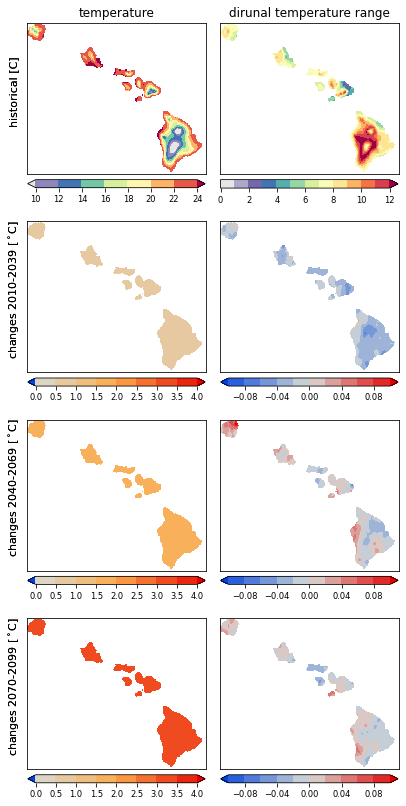

In [85]:
fig, axes = plt.subplots(nrows=4, ncols=2, sharex=True, sharey=True, figsize=(5.5, 11.25))
plt.subplots_adjust(left=0.045, bottom=0.0125, right=0.985, top=0.975, hspace=0.075, wspace=0.075)

for col, var in enumerate(['tmean','dtr']):
    histo_tair_ann.mean(dim='gcm')[var].plot.pcolormesh(ax=axes[0, col], **kwargs[var])
    rcp85_ann_tair_30yr_diff['early'].mean(dim='gcm')[var].plot.pcolormesh(ax=axes[1, col],  **kwargs[f'change_{var}'])
    rcp85_ann_tair_30yr_diff['middle'].mean(dim='gcm')[var].plot.pcolormesh(ax=axes[2, col], **kwargs[f'change_{var}'])
    rcp85_ann_tair_30yr_diff['late'].mean(dim='gcm')[var].plot.pcolormesh(ax=axes[3, col],   **kwargs[f'change_{var}'])
    
    add_ylabel(axes[0, 0], 'historical [C]', fontsize=11)
    add_ylabel(axes[1, 0], 'changes 2010-2039 [$^\circ$C]', fontsize=11)
    add_ylabel(axes[2, 0], 'changes 2040-2069 [$^\circ$C]', fontsize=11)
    add_ylabel(axes[3, 0], 'changes 2070-2099 [$^\circ$C]', fontsize=11)
    axes[0, col].set_title(var_title[var], fontsize=12)
    
#plt.tight_layout()
if figSave:
    plt.savefig(f'NB-HI3_Fig1_annual_mean_change_temperature_rcp85.png', dpi=300)

------------
 - The same as above except for two future periods in 21st century (early, mid, and late) 

/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizuka

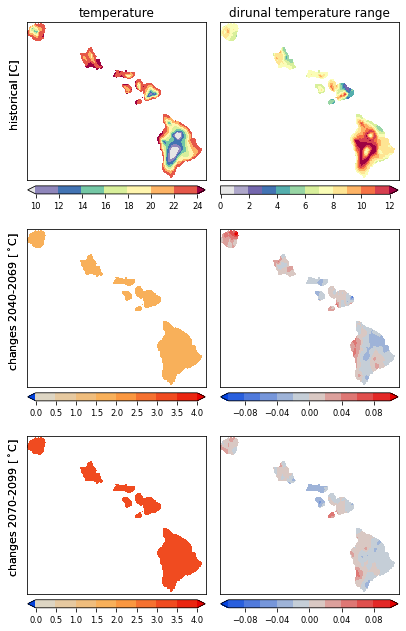

In [86]:
fig, axes = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True, figsize=(5.5,8.75))
plt.subplots_adjust(left=0.045, bottom=0.0125, right=0.985, top=0.975, hspace=0.075, wspace=0.075)

for col, var in enumerate(['tmean','dtr']):
    histo_tair_ann.mean(dim='gcm')[var].plot.pcolormesh(ax=axes[0, col], **kwargs[var])
    rcp85_ann_tair_30yr_diff['middle'].mean(dim='gcm')[var].plot.pcolormesh(ax=axes[1, col], **kwargs[f'change_{var}'])
    rcp85_ann_tair_30yr_diff['late'].mean(dim='gcm')[var].plot.pcolormesh(ax=axes[2, col],   **kwargs[f'change_{var}'])
    
    add_ylabel(axes[0, 0], 'historical [C]', fontsize=11)
    add_ylabel(axes[1, 0], 'changes 2040-2069 [$^\circ$C]', fontsize=11)
    add_ylabel(axes[2, 0], 'changes 2070-2099 [$^\circ$C]', fontsize=11)
    axes[0, col].set_title(var_title[var], fontsize=12)
    
if figSave:
    plt.savefig(f'NB-HI3_Fig2_annual_mean_change_temperature_mid_late_rcp85.png', dpi=300)

------------
 - Difference between two RCPs in 30yr mean change for late 21st century

/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


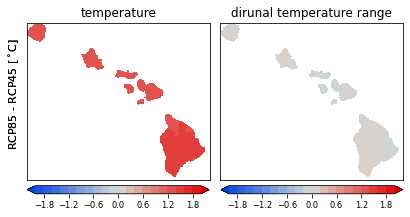

In [87]:
cm = {'change' : custom_div_cmap(numcolors=256, mincol='xkcd:blue', midcol='xkcd:light grey', maxcol='xkcd:red')}

style_kwargs = {'add_labels': False, 'xticks':[], 'yticks':[], 'cbar_kwargs': dict(orientation="horizontal", shrink=0.995, pad=0.03)}
kwargs       = {'change-rcp': {'levels':21,'vmin':-2, 'vmax':2,  'cmap':cm['change'], 'extend':'both', **style_kwargs}}

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(5.5,3))
plt.subplots_adjust(left=0.040, bottom=0.0125, right=0.990, top=0.900, hspace=0.060, wspace=0.060)

for col, var in enumerate(['tmean','dtr']):
    diff_rcp_ann_tair_30yr_change['late'].mean(dim='gcm')[var].plot.pcolormesh(ax=axes[col], **kwargs['change-rcp'])
    
    add_ylabel(axes[0], 'RCP85 - RCP45 [$^\circ$C]', fontsize=11)
    axes[col].set_title(var_title[var], fontsize=12)
    
if figSave:
    plt.savefig(f'NB-HI3_Fig3_annual_mean_temperature_late_diff_rcp.png', dpi=300)

--------
- annual temperature changes for individual GCMs for late 21st century are plotted below

--------------------
### mean temperature

#### rcp45

/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


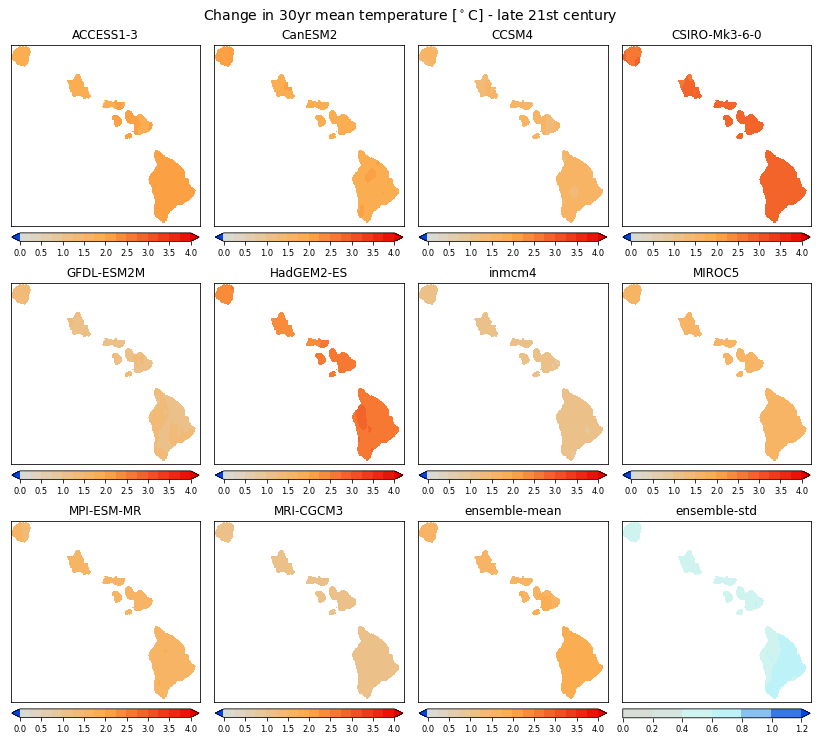

In [80]:
var="tmean"

cm = {'mean': cmap_change_tmean,
      'std' : custom_div_cmap(numcolors=16, mincol='xkcd:light grey', midcol='xkcd:light light blue', maxcol='xkcd:blue')}

style_kwargs = {'add_labels': False, 'xticks':[], 'yticks':[], 'cbar_kwargs': {"orientation":"horizontal", "shrink":0.990, "pad":0.03}}

kwargs = {'mean': {'levels': 17, 'vmin':0, 'vmax':4, 'cmap':cm['mean'], 'extend':'both', **style_kwargs},
          'std':  {'levels': 7, 'vmin':0, 'vmax':1.2,  'cmap':cm['std'],  'extend':'max',  **style_kwargs}}

fig, axes = plt.subplots(nrows=3, ncols=4, sharex=True, sharey=True, figsize=(11.375, 10.5)) # used to be figsize=(14,11)
plt.subplots_adjust(left=0.0125, bottom=0.0125, right=0.99, top=0.935, hspace=0.075, wspace=0.075)

for ix, gcm in enumerate(gcms+['ensemble-mean','ensemble-std']):
    row = ix // 4
    col = ix % 4
    if ix < 10:
        rcp45_ann_tair_30yr_diff['late'][var].sel(gcm=gcm).plot.pcolormesh(ax=axes[row, col], **kwargs['mean'])
    elif ix == 10:
        rcp45_ann_tair_30yr_diff['late'].mean(dim='gcm')[var].plot.pcolormesh(ax=axes[row, col], **kwargs['mean'])
    elif ix == 11:
        rcp45_ann_tair_30yr_diff['late'].std(dim='gcm')[var].plot.pcolormesh(ax=axes[row, col], **kwargs['std'])
    axes[row, col].set_title(gcm, fontsize=12)
    
#plt.tight_layout()
fig.suptitle('Change in 30yr mean temperature [$^\circ$C] - late 21st century', fontsize=14, y=0.985)
if figSave:
    plt.savefig(f'NB-HI3_Fig4_annual_mean_temperature_late_{var}_rcp45.png', dpi=300)

#### rcp85

/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


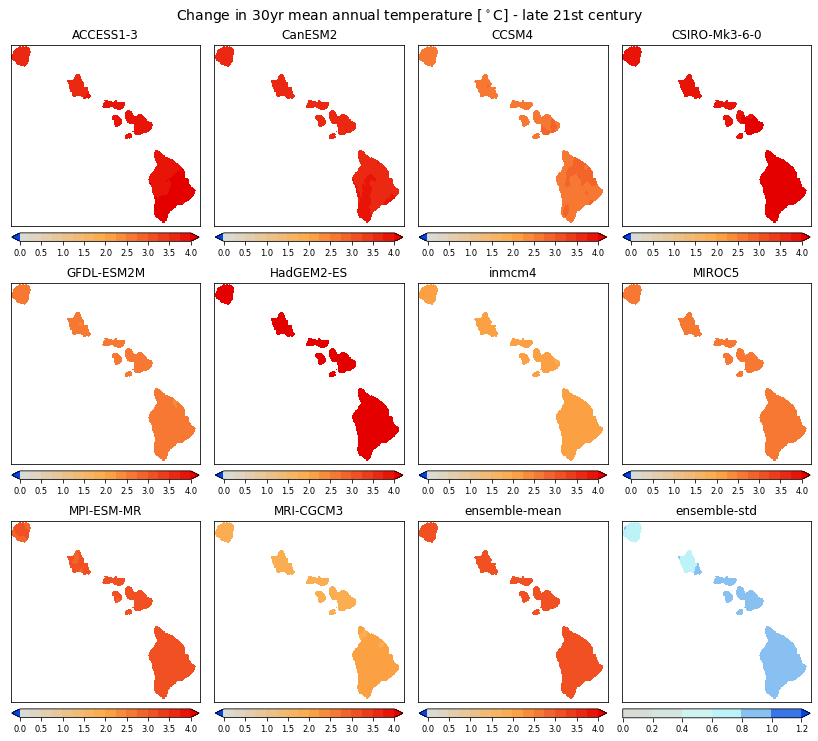

In [79]:
var="tmean"

cm = {'mean': cmap_change_tmean,
      'std' : custom_div_cmap(numcolors=16, mincol='xkcd:light grey', midcol='xkcd:light light blue', maxcol='xkcd:blue')}

style_kwargs = {'add_labels': False, 'xticks':[], 'yticks':[], 'cbar_kwargs': {"orientation":"horizontal", "shrink":0.990, "pad":0.03}}

kwargs = {'mean': {'levels': 17, 'vmin':0, 'vmax':4,   'cmap':cm['mean'], 'extend':'both', **style_kwargs},
          'std':  {'levels': 7,  'vmin':0, 'vmax':1.2, 'cmap':cm['std'],  'extend':'max',  **style_kwargs}}

fig, axes = plt.subplots(nrows=3, ncols=4, sharex=True, sharey=True, figsize=(11.375, 10.5))  # used to be figsize=(14,11)

plt.subplots_adjust(left=0.0125, bottom=0.0125, right=0.99, top=0.935, hspace=0.075, wspace=0.075)

for ix, gcm in enumerate(gcms+['ensemble-mean','ensemble-std']):
    row = ix // 4
    col = ix % 4
    if ix < 10:
        rcp85_ann_tair_30yr_diff['late'][var].sel(gcm=gcm).plot.pcolormesh(ax=axes[row, col], **kwargs['mean'])
    elif ix == 10:
        rcp85_ann_tair_30yr_diff['late'].mean(dim='gcm')[var].plot.pcolormesh(ax=axes[row, col], **kwargs['mean'])
    elif ix == 11:
        rcp85_ann_tair_30yr_diff['late'].std(dim='gcm')[var].plot.pcolormesh(ax=axes[row, col], **kwargs['std'])
    axes[row, col].set_title(gcm, fontsize=12)
    
fig.suptitle('Change in 30yr mean annual temperature [$^\circ$C] - late 21st century', fontsize=14, y=0.985)
if figSave:
    plt.savefig(f'NB-HI3_Fig5_annual_mean_temperature_late_{var}_rcp85.png', dpi=300)

------------
 - Change in 30yr seasonal temperature between historical and three future periods in 21st century (early, mid, and late) 

In [82]:
# some local plot setups

cm = {'history' : cmap,
      'change'  : cmap_change_tseason}

cbar_kwrgs = {'mean':   {"orientation":"horizontal", "shrink":0.990, "pad":0.03},
              'change': {"orientation":"horizontal", "shrink":0.990, "pad":0.03}}

style_kwargs = {'mean':   {'add_labels': False, 'xticks':[], 'yticks':[], 'cbar_kwargs': cbar_kwrgs['mean']},
                'change': {'add_labels': False, 'xticks':[], 'yticks':[], 'cbar_kwargs': cbar_kwrgs['change']}
               }

kwargs = {'change': {'levels': 11, 'vmin':0, 'vmax':4,   'cmap':cm['change'],  'extend':'both', **style_kwargs['change']},
          'tmean':  {'levels': 8, 'vmin':10, 'vmax':24,  'cmap':cm['history'], 'extend':'both', **style_kwargs['mean']}}

/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizuka

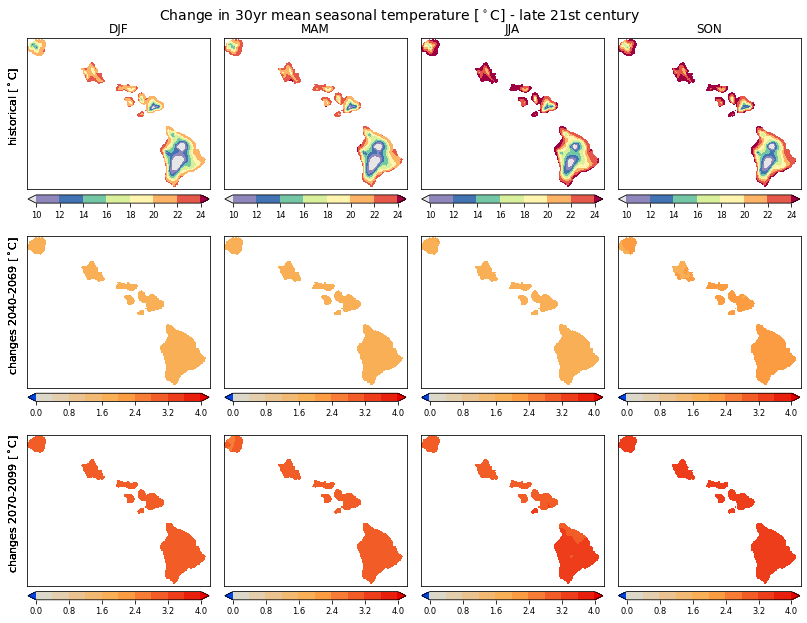

In [83]:
fig, axes = plt.subplots(nrows=3, ncols=4, sharex=True, sharey=True, figsize=(11.37, 8.75))
plt.subplots_adjust(left=0.045, bottom=0.0125, right=0.99, top=0.935, hspace=0.075, wspace=0.075)

for col, season in enumerate(['DJF','MAM','JJA','SON']):
    histo_tair_season.mean(dim='gcm')['tmean'].sel(season=season).plot.pcolormesh(ax=axes[0, col], **kwargs['tmean'])
    rcp85_season_tair_30yr_diff['middle'].mean(dim='gcm')['tmean'].sel(season=season).plot.pcolormesh(ax=axes[1, col], **kwargs[f'change'])
    rcp85_season_tair_30yr_diff['late'].mean(dim='gcm')['tmean'].sel(season=season).plot.pcolormesh(ax=axes[2, col],   **kwargs[f'change'])
    
    add_ylabel(axes[0, 0], 'historical [$^\circ$C]', fontsize=11)
    add_ylabel(axes[1, 0], 'changes 2040-2069 [$^\circ$C]', fontsize=11)
    add_ylabel(axes[2, 0], 'changes 2070-2099 [$^\circ$C]', fontsize=11)
    axes[0, col].set_title(season, fontsize=12)
    
fig.suptitle('Change in 30yr mean seasonal temperature [$^\circ$C] - late 21st century', fontsize=14, y=0.985)
if figSave:
    plt.savefig(f'NB-HI3_Fig6_seasonal_mean_change_temperature_mid_late_rcp85.png', dpi=300)

## Cofficient of variation of future changes for each variables

/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


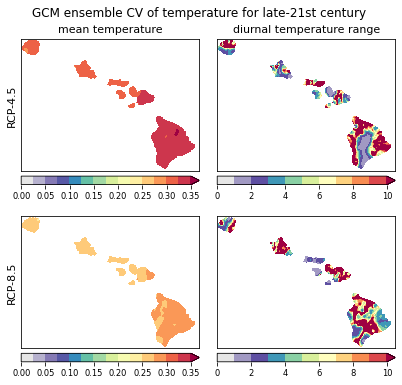

In [75]:
# uncertainty
cm = {'cv': cmap}

style_kwargs =  {'add_labels': False, 'xticks':[], 'yticks':[], 'cbar_kwargs': dict(orientation="horizontal", pad=0.03)}

kwargs = {'cv_tmean': {'levels': 15, 'vmin':0, 'vmax':0.35, 'cmap':cm['cv'], 'extend':'max', **style_kwargs},
          'cv_dtr':   {'levels': 11, 'vmin':0, 'vmax':10.0, 'cmap':cm['cv'], 'extend':'max', **style_kwargs}}

var_title = {'tmean':'mean temperature', 'dtr':'diurnal temperature range'}

fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(5.5, 5.25)) # used to be figsize=(14,11)
plt.subplots_adjust(left=0.05, bottom=0.005, right=0.995, top=0.900, hspace=0.1, wspace=0.1)

mean ={}; std={}; cv={}
for ix, var in enumerate(met_vars):
    
    mean[var] = {45: rcp45_ann_tair_30yr_diff['late'].mean(dim='gcm')[var],
                 85: rcp85_ann_tair_30yr_diff['late'].mean(dim='gcm')[var]}
    
    std[var]  = {45: rcp45_ann_tair_30yr_diff['late'].std(dim='gcm')[var],
                 85: rcp85_ann_tair_30yr_diff['late'].std(dim='gcm')[var]}
    
    cv[var]   = {45: std[var][45]/abs(mean[var][45]),
                 85: std[var][85]/abs(mean[var][85])}
    
    cv[var][45].plot.pcolormesh(ax=axes[0,ix], **kwargs[f'cv_{var}'])
    cv[var][85].plot.pcolormesh(ax=axes[1,ix], **kwargs[f'cv_{var}'])
    axes[0,0].set_ylabel('RCP-4.5', fontsize=11)
    axes[1,0].set_ylabel('RCP-8.5', fontsize=11)
    axes[0,ix].set_title('%s'%var_title[var], fontsize=11)    
    
fig.suptitle('GCM ensemble CV of temperature for late-21st century', fontsize=12, y=0.985)
if figSave:
    plt.savefig(f'NB-HI3_Fig7_cv_change_rcp85.png', dpi=300)

In [76]:
class AutoVivification(dict):
    """Implementation of perl's autovivification feature to initialize structure."""
    def __getitem__(self, item):
        try:
            return dict.__getitem__(self, item)
        except KeyError:
            value = self[item] = type(self)()
        return value

In [77]:
# Get std and cv stats over the domain
quantile_list = [0.02,0.1,0.2,0.5,0.8,0.9,0.98]
mean_list = AutoVivification() 
std_list  = AutoVivification()  
cv_list   = AutoVivification()

for jx, rcp in enumerate([45,85]):
    for ix, var in enumerate(met_vars):
        
        #mask out grid boxes with small mean values (< median)
        med = np.nanquantile(mean[var][rcp].values,0.5)
        masked_mean = mean[var][rcp].where(mean[var][rcp]>med)
        masked_std  = std[var][rcp].where(mean[var][rcp]>med)
        masked_cv   = cv[var][rcp].where(mean[var][rcp]>med)
    
        mean_list[var][rcp] = np.nanquantile(mean[var][rcp].values, quantile_list).tolist()
        std_list[var][rcp]  = np.nanquantile(std[var][rcp].values,  quantile_list).tolist()
        cv_list[var][rcp]   = np.nanquantile(cv[var][rcp].values,   quantile_list).tolist()

/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizuka

In [78]:
for rcp in [45,85]:
    print(f'rcp-{rcp}')
    for ix, var in enumerate(met_vars):
        print(f'{var}')
        print('quantile:', *quantile_list)
        print('mean    :', *mean_list[var][rcp])
        print('std.dev :', *std_list[var][rcp])
        print('C.V.    :', *cv_list[var][rcp])
        print('\n')

rcp-45
tmean
quantile: 0.02 0.1 0.2 0.5 0.8 0.9 0.98
mean    : 1.713871703147888 1.7271952867507934 1.739613652229309 1.7915823459625244 1.8012138605117798 1.8043327331542969 1.8101704025268557
std.dev : 0.5223726010322571 0.5301128029823303 0.5469993352890015 0.5948996543884277 0.6100303292274475 0.6139328122138977 0.6232832407951355
C.V.    : 0.3017409837245941 0.30711901783943174 0.3160263001918793 0.3314523696899414 0.33992108702659607 0.3422973811626434 0.3484209907054901


dtr
quantile: 0.02 0.1 0.2 0.5 0.8 0.9 0.98
mean    : -0.04557901531457901 -0.03177818357944488 -0.025831546634435654 -0.010935401543974876 -1.51443480717664e-05 0.006505966279655703 0.023746405392885216
std.dev : 0.04164658442139625 0.052100645005702974 0.05902833640575409 0.07450232654809952 0.08634784370660784 0.09503663480281829 0.12320054918527604
C.V.    : 1.4180849695205688 1.811474871635437 2.55185661315918 6.101707458496094 14.756693458557145 27.360250473022464 122.268864440918


rcp-85
tmean
quantile:

In [ ]:
6.5*1.8

In [ ]:
6*1.8

In [ ]:
8.125/3*2